## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Build KNN Class

In [2]:
class KNN():
    def __init__(self, k, metric='euclidean', task='classification'):
        self.k = k
        self.metric = metric
        self.task = task
        self.X_train = None
        self.y_train = None
    
    def euclidean(self, v1, v2):
        return np.sqrt(np.sum((v1-v2)**2))
    
    def manhattan(self, v1, v2):
        return np.sum(np.abs(v1-v2))

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X_test):
        preds = []
        for test_row in X_test:
            nearest_neighbours = self.get_neighbours(test_row)
            if self.task == "classification" :
                majority = max(nearest_neighbours, key=lambda x: nearest_neighbours.count(x))
                preds.append(majority)
            elif self.task == "regression" :
                average_value = np.mean(nearest_neighbours)
                preds.append(average_value)
            else :
                print("Task harus berupa classification atau regression")
        return np.array(preds)
    
    def get_neighbours(self, test_row):
        distances = []
        
        for (train_row, train_class) in zip(self.X_train, self.y_train):
            if self.metric=='euclidean':
                dist = self.euclidean(train_row, test_row)
            elif self.metric=='manhattan':
                dist = self.manhattan(train_row, test_row)
            else:
                raise NameError('Jarak harus berupa euclidean atau manhattan')
            distances.append((dist, train_class))
            
        distances.sort(key=lambda x: x[0])
        
        neighbours = []
        for i in range(self.k):
            neighbours.append(distances[i][1])
            
        return neighbours

## Load data

In [3]:
df = pd.read_csv('dataset.csv')
df.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Class
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0


In [4]:
df.dtypes

Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Class               int64
dtype: object

In [5]:
df['Class'].unique()

array([1, 0], dtype=int64)

In [6]:
df.shape

(4177, 8)

In [7]:
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Class
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,0.229830
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,0.420774
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,0.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,0.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,0.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,0.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,1.000000


# Classification

### Preprocessing

In [8]:
# cek jumlah baris pada setiap atribut yang mempunyai nilai null atau kosong
df.isnull().sum()

Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Class             0
dtype: int64

In [9]:
# cek jumlah outliers pada setiap atribut
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

IQR = Q3 - Q1
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR

outliers = (df < lower_limit) | (df > upper_limit)
print ("Outlier pada tiap atribut:")
print(outliers.sum())

Outlier pada tiap atribut:
Length             49
Diameter           59
Height             29
Whole weight       30
Shucked weight     48
Viscera weight     26
Shell weight       35
Class             960
dtype: int64


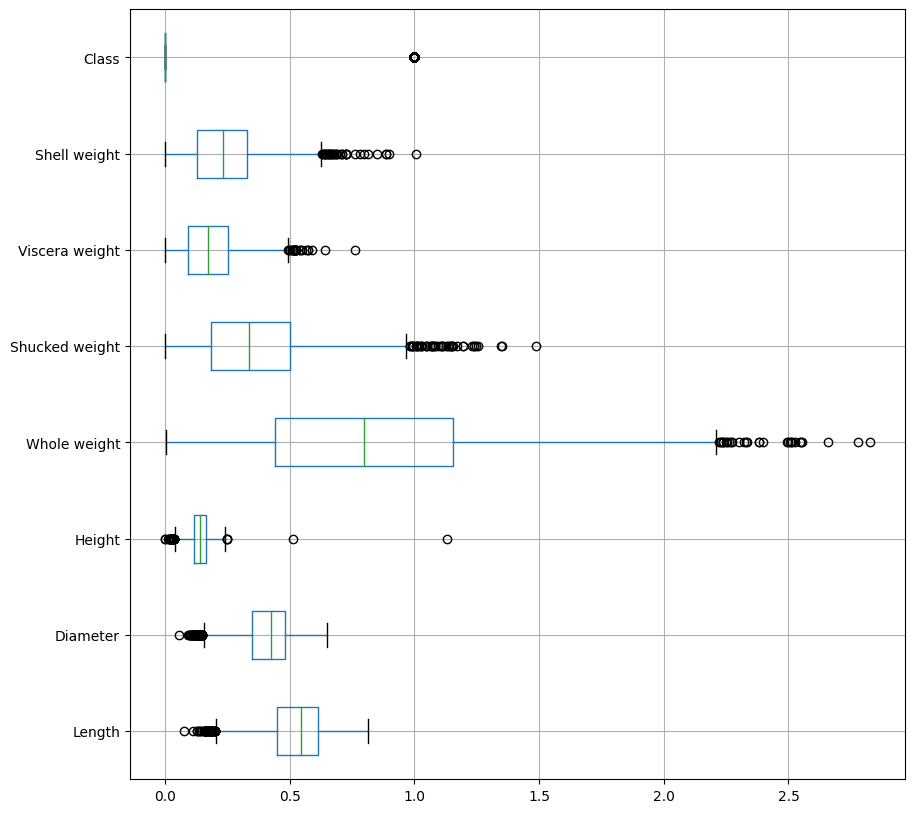

In [13]:
df.boxplot(vert=False, figsize=(10,10))
plt.show()

In [10]:
# cek jumlah duplikasi
df.duplicated().sum()

0

In [11]:
# cek jumlah value pada atribut class 
from collections import Counter
counter_y = Counter(df['Class'])
print(counter_y)

Counter({0: 3217, 1: 960})


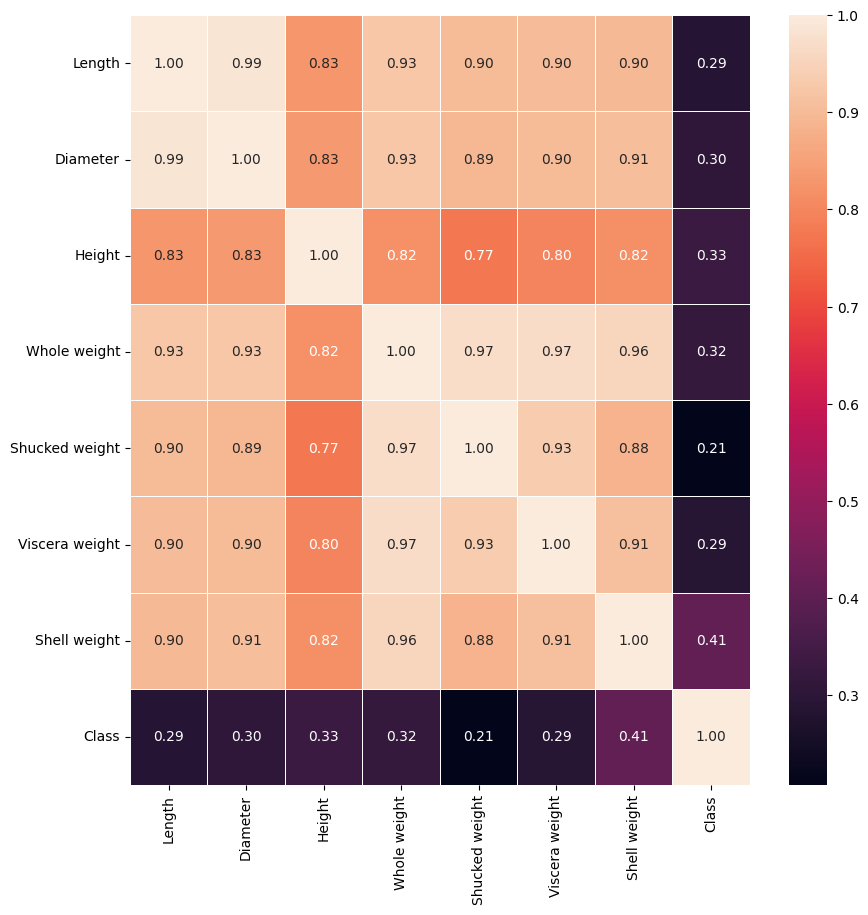

In [12]:
# cek korelasi antar atribut
correlation = df.corr(method='pearson')
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlation, annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.show()

In [14]:
# feature selection
X = df.drop(["Class"],axis=1)
y = df["Class"]

### Split data

In [15]:
# split data dengan proporsi data training 80%, data testing 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [16]:
# scale feature
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

### Train and test the model

In [65]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def metrics_reg(y_test, prediction):
    print(f'MAE: {mean_absolute_error(y_test, prediction):.3f}')
    print(f'MSE: {mean_squared_error(y_test, prediction):.3f}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_test, prediction)):.3f}')
    print(f'R_squared:  {r2_score(y_test, prediction):.3f}')

In [52]:
from sklearn.metrics import accuracy_score, f1_score
def metrics_class(y_test, prediction):
    print(f'Accuracy: {accuracy_score(y_test, prediction):.3f}')
    print(f'F1 Score: {f1_score(y_test, prediction):.3f}')

In [53]:
for metric in ['euclidean', 'manhattan']:
    print(f"Metrics : {metric}")
    clf = KNN(k=5, metric=metric)
    clf.fit(X_train_scaled, y_train)
    preds = clf.predict(X_test_scaled)
    metrics_class(y_test, preds)

Metrics : euclidean
Accuracy: 0.818
F1 Score: 0.528
Metrics : manhattan
Accuracy: 0.836
F1 Score: 0.571


### Hyperparameter tuning

Text(0.5, 1.0, 'k vs accuracy')

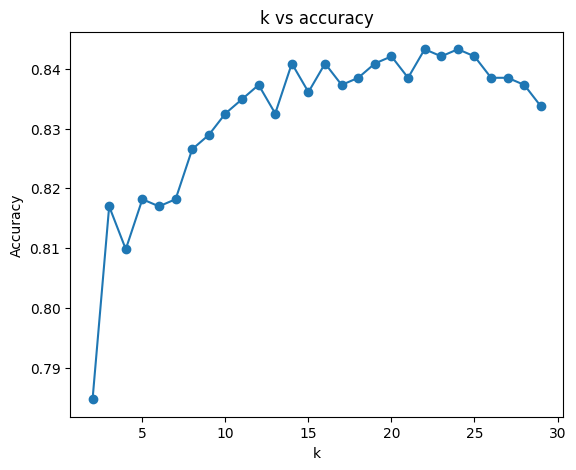

In [44]:
k_max = 30
accuracies = []
best_k = []
for k in range(2,k_max):
    clf = KNN(k=k, metric='euclidean')
    clf.fit(X_train_scaled, y_train)
    preds = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)
    best_k.append((k,acc))

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(range(2,k_max), accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k vs accuracy')

In [45]:
sorted_list = sorted(best_k, key=lambda x: x[1])
print(f"Metrics: euclidean\nBest k: {sorted_list[-1][0]}\nBest acc: {sorted_list[-1][1]}")

Metrics: euclidean
Best k: 24
Best acc: 0.8433014354066986


Text(0.5, 1.0, 'k vs accuracy')

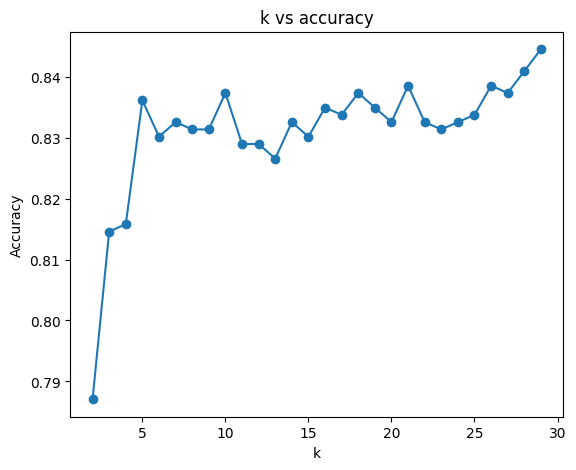

In [46]:
k_max = 30
accuracies = []
best_k = []
for k in range(2,k_max):
    clf = KNN(k=k, metric='manhattan')
    clf.fit(X_train_scaled, y_train)
    preds = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)
    best_k.append((k,acc))

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(range(2,k_max), accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k vs accuracy')

In [47]:
sorted_list = sorted(best_k, key=lambda x: x[1])
print(f"Metrics: manhattan\nBest k: {sorted_list[-1][0]}\nBest acc: {sorted_list[-1][1]}")

Metrics: manhattan
Best k: 29
Best acc: 0.8444976076555024


# Regression

### Preprocessing

In [ ]:
# tahapan preprocessing sama seperti yang sudah dilakukan sebelumnya pada saat classification

In [48]:
X_2 = df[["Length", 'Height']]
y_2 = df["Viscera weight"]

### Split data

In [49]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=4)

In [50]:
# scale feature
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled_2 = scaler.fit_transform(X_train_2) 
X_test_scaled_2 = scaler.transform(X_test_2)

### Train and test the model

In [62]:
print(y_test_2)

1838    0.0625
863     0.1695
3098    0.1220
1981    0.3605
1544    0.0460
         ...  
537     0.0255
4020    0.2820
553     0.1310
4042    0.1945
3670    0.1990
Name: Viscera weight, Length: 836, dtype: float64


In [66]:
for metric in ['euclidean', 'manhattan']:
    print(f"Metrics : {metric}")
    clf_2 = KNN(k=5, metric=metric, task='regression')
    clf_2.fit(X_train_scaled_2, y_train_2)
    preds_2 = clf_2.predict(X_test_scaled_2)
    metrics_reg(y_test_2.values, preds_2)

Metrics : euclidean
MAE: 0.027
MSE: 0.002
RMSE: 0.039
R_squared:  0.871
Metrics : manhattan
MAE: 0.027
MSE: 0.002
RMSE: 0.039
R_squared:  0.870


### Hyperparameter tuning

Text(0.5, 1.0, 'k vs R2 Score')

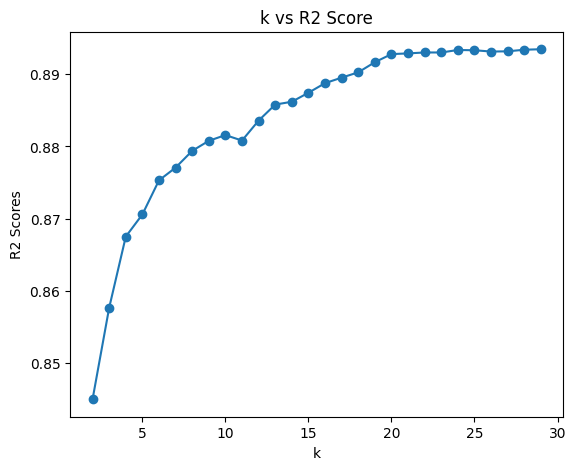

In [68]:
k_max = 30
r2_scores = []
best_k = []

for k in range(2,k_max):
    clf_2 = KNN(k=k, metric='euclidean', task='regression')
    clf_2.fit(X_train_scaled_2, y_train_2)
    preds_2 = clf_2.predict(X_test_scaled_2)
    r2 = r2_score(y_test_2.values, preds_2)
    r2_scores.append(r2)
    best_k.append((k, r2))

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(range(2,k_max), r2_scores, marker='o')
plt.xlabel('k')
plt.ylabel('R2 Scores')
plt.title('k vs R2 Score')

In [69]:
sorted_list = sorted(best_k, key=lambda x: x[1])
print(f"Metrics: euclidean\nBest k: {sorted_list[-1][0]}\nBest r2: {sorted_list[-1][1]}")

Metrics: euclidean
Best k: 29
Best r2: 0.8934610694936929


Text(0.5, 1.0, 'k vs R2 Score')

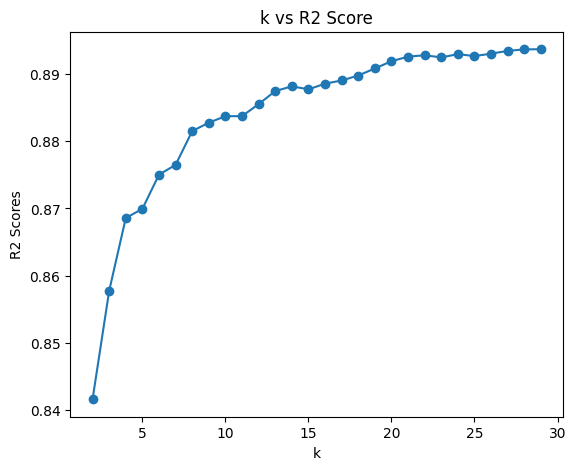

In [71]:
k_max = 30
r2_scores = []
best_k = []

for k in range(2,k_max):
    clf_2 = KNN(k=k, metric='manhattan', task='regression')
    clf_2.fit(X_train_scaled_2, y_train_2)
    preds_2 = clf_2.predict(X_test_scaled_2)
    r2 = r2_score(y_test_2.values, preds_2)
    r2_scores.append(r2)
    best_k.append((k, r2))

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(range(2,k_max), r2_scores, marker='o')
plt.xlabel('k')
plt.ylabel('R2 Scores')
plt.title('k vs R2 Score')

In [72]:
sorted_list = sorted(best_k, key=lambda x: x[1])
print(f"Metrics: manhattan\nBest k: {sorted_list[-1][0]}\nBest r2: {sorted_list[-1][1]}")

Metrics: manhattan
Best k: 29
Best r2: 0.8936781807050485


# Pertanyaan

1. Apa saja pertimbangan yang harus diperhatikan dalam menentukan nilai k?

Untuk menentukan nilai k, ada beberapa hal yang perlu diketahui. Nilai k yang terlalu kecil akan menyebabkan model sensitif terhadap noise dan membuat model menjadi overfitting. Namun, nilai k yang terlalu besar juga dapat menyebabkan model menjadi underfit dan merusak aspek lokalitas. Jika dataset memiliki banyak noise atau outlier, memilih nilai k yang lebih besar dapat membantu mengurangi dampak dari data yang tidak representatif. Pilihan fungsi jarak atau metrik dapat mempengaruhi pemilihan nilai k. 

2. Untuk Classification dan Regression, bagaimana hasil percobaan antara menggunakan euclidean distance dan manhattan distance untuk nilai k yang sama? Apa yang menyebabkan hal tersebut terjadi?

Berdasarkan hasil percobaan di atas, untuk classification dengan nilai k = 5, rumus jarak yang dapat memberikan hasil terbaik adalah dengan menggunakan manhattan distance. Hal ini bisa disebabkan karena Euclidean distance lebih sensitif terhadap adanya outlier karena menggunakan kuadrat jarak antar titik. Jika terdapat titik-titik yang sangat jauh dari sebagian besar titik lainnya, hal ini dapat mempengaruhi hasil secara signifikan. Di lain sisi, Manhattan distance, dengan mengukur jarak sepanjang sumbu, kurang dipengaruhi oleh perbedaan besar pada satu dimensi tertentu. Outliers pada data ini juga tidak dibuang pada saat preprocessing, yang mana mendukung alasan ini. Lalu, karena semua fitur digunakan dalam perhitungan, dalam ruang berdimensi tinggi (high-dimensional space), efek dari "curse of dimensionality" dapat mempengaruhi performa Euclidean distance, sedangkan Manhattan distance dapat lebih stabil. 

Untuk regression, untuk nilai k = 5, performa dengan menggunakan kedua rumus jarak relatif sama. Hal ini bisa disebabkan karena hanya ada 2 fitur yang digunakan dan kedua fitur tersebut memiliki hubungan yang relatif linear sehingga kedua rumus jarak tidak terlalu memberikan dampak yang signifikan.

3. Untuk Classification dan Regression, berdasarkan hasil hyperparameter tuning, apa rumus jarak dan nilai k yang paling optimal? Apa performance metrics yang Anda gunakan? Jelaskan dengan menyertakan alasannya

Berdasarkan hasil parameter tuning, untuk classification, nilai k yang paling optimal adalah 29 dengan rumus jarak manhattan. Performance metrics yang digunakan adalah accuracy, yang mana dapat mengukur berapa banyak hasil prediksi yang benar dari seluruh prediksi. Meskipun data tidak terlalu balance, nilai accuracy disini masih bisa dijadikan acuan, kecuali data yang ada sangat tidak balance, maka akan lebih baik menggunakan nilai F1.

Untuk regression, nilai k yang paling optimal adalah 10 dengan rumus jarak euclidean karena berdasarkan grafik, apabila nilai k makin tinggi, maka nilai R2 juga makin tinggi, ada kemungkinan nilai k yang makin tinggi menyebabkan model menjadi underfit. Performance metrics yang digunakan adalah R2 atau R square karena R2 dapat memberikan indikasi sejauh mana model regresi dapat menjelaskan variasi dalam data target. Makin tinggi nilai R2, semakin baik model dapat menjelaskan variasi dalam data.

4. Untuk Classification, apa variabel yang Anda pilih untuk memprediksi Class dari kerang Abalone? Jelaskan mengapa Anda memilih variabel tersebut

Untuk classification, semua variabel digunakan karena memiliki nilai korelasi yang tidak terlalu buruk terhadap class. Jika Anda memiliki sejumlah besar fitur tetapi hanya sebagian saja yang relevan dengan tugas klasifikasi Anda, menggunakan semua fitur dapat menimbulkan noise dan mengurangi kinerja model. Dalam kasus seperti itu, pemilihan fitur atau teknik pengurangan dimensi (misalnya, PCA) dapat diterapkan untuk mempertahankan hanya fitur yang paling informatif.

5. Apa pertimbangan dalam memilih kNN dibandingkan dengan metode classification dan regression lainnya? Jelaskan juga pada saat kondisi apa metode classification dan regression dapat bekerja dengan lebih baik

Pemilihan metode kNN dibandingkan dengan metode klasifikasi dan regresi lainnya harus mempertimbangkan karakteristik data dan tujuan analisis. kNN dapat berhasil menangani masalah klasifikasi dan regresi pada data yang memiliki pola nonlinear dan kompleks. Ini cocok untuk situasi di mana hubungan antara variabel tidak terlalu terstruktur. kNN juga dapat lebih tahan terhadap outlier karena mempertimbangkan beberapa tetangga terdekat dalam proses pengambilan keputusan.

6. Apa yang Anda ketahui tentang weighted k-NN?

Weighted kNN adalah variasi dari algoritma kNN di mana bobot (weights) diberikan kepada setiap tetangga terdekat selama proses prediksi. Dalam kNN biasa, setiap tetangga diberi kontribusi yang sama terhadap hasil prediksi. Namun, pada Weighted kNN, bobot diterapkan agar tetangga yang lebih dekat memberikan pengaruh yang lebih besar daripada tetangga yang lebih jauh. 

Keuntungan dari Weighted kNN adalah memungkinkan model untuk memberikan perhatian lebih besar pada tetangga yang lebih relevan dan memiliki dampak yang lebih signifikan terhadap prediksi. Hal ini dapat meningkatkan akurasi model, terutama dalam situasi di mana beberapa tetangga lebih informatif daripada yang lain.